In [337]:
#Data Fetching
!pip install opencv-contrib-python
!pip install tensorflow opencv-python-headless matplotlib
from IPython.display import clear_output
!unzip "/content/training_images.zip" -d "/content/training_images"
!unzip "/content/training_labels.zip" -d "/content/training_labels"
!pip install tensorflow==2.17.0
clear_output()

In [338]:
# Useful imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import StringLookup

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv

import matplotlib.font_manager as fm
import tensorflow as tf

# Load an Urdu font
font_path = "/content/UrdType.ttf"  # Adjust the path to your Urdu font
font_prop = fm.FontProperties(fname=font_path)

np.random.seed(42)
tf.random.set_seed(42)


In [339]:
filenames_img=sorted(os.listdir('/content/training_images'))
filenames_gt=sorted(os.listdir('/content/training_labels'))
filenames_imgsplit=[filename.replace('.jpg', '') for filename in filenames_img]
filenames_gtsplit=[filename.replace('.txt', '') for filename in filenames_gt]
print(len(filenames_imgsplit))
print(len(filenames_gtsplit))

80
80


In [340]:
#train test validate splitting
split_idx = int(0.8 * len(filenames_imgsplit))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgsplit[:split_idx]
test_samples = filenames_img[split_idx:]
test_samples_split = filenames_imgsplit[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
validation_samples_split = test_samples_split[:val_split_idx]
test_samples = test_samples[val_split_idx:]
test_samples_split = test_samples_split[val_split_idx:]

assert len(filenames_imgsplit) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f' Example from training dataset {train_samples_split[0]}')

Total training samples: 64
Total validation samples: 8
Total test samples: 8
 Example from training dataset 0


In [341]:
import os

base_path = '/content/'
base_image_path = os.path.join(base_path, "training_images/")
base_GT_path = os.path.join(base_path, "training_labels/")

def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []

    # List all files in Total GT directory for debugging
    # print("Files in Total GT directory:")
    num = 1;

    for filename in os.listdir(base_GT_path):
        # print("Run:", num)
        print(filename)
        # num += 1

    for i in range(len(filenames_imgsplit)):
        img_path = os.path.join(base_image_path, filenames_img[i])

        # Check if the image file exists and is not empty
        if os.path.exists(img_path) and os.path.getsize(img_path) > 0:
            paths.append(img_path)

            # Remove .png from the filename and add .txt for the label
            label_filename = os.path.splitext(os.path.basename(filenames_imgsplit[i]))[0] + '.txt'
            label_path = os.path.join(base_GT_path, label_filename)

            # print(f"Checking label file: {label_path}")

            # Check if the label file exists
            if os.path.exists(label_path):
                with open(label_path, "r") as label_file:
                    labels.append(label_file.read())
            else:
                print(f"Label file not found: {label_path}")
        else:
            print(f"Image file not found or is empty: {img_path}")



    return paths, labels

# Call the function for your datasets
train_img_paths, train_labels = get_image_paths_and_labels(train_samples, train_samples_split)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples, validation_samples_split)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)


47.txt
75.txt
39.txt
11.txt
55.txt
0.txt
13.txt
9.txt
72.txt
56.txt
63.txt
38.txt
17.txt
16.txt
14.txt
42.txt
7.txt
64.txt
33.txt
31.txt
53.txt
41.txt
10.txt
22.txt
62.txt
30.txt
27.txt
40.txt
79.txt
26.txt
35.txt
21.txt
19.txt
76.txt
66.txt
69.txt
37.txt
24.txt
59.txt
58.txt
32.txt
2.txt
5.txt
1.txt
78.txt
65.txt
4.txt
15.txt
28.txt
71.txt
23.txt
49.txt
8.txt
20.txt
25.txt
60.txt
6.txt
12.txt
36.txt
61.txt
29.txt
77.txt
34.txt
73.txt
46.txt
48.txt
45.txt
57.txt
50.txt
51.txt
52.txt
54.txt
74.txt
68.txt
67.txt
3.txt
18.txt
43.txt
70.txt
44.txt
47.txt
75.txt
39.txt
11.txt
55.txt
0.txt
13.txt
9.txt
72.txt
56.txt
63.txt
38.txt
17.txt
16.txt
14.txt
42.txt
7.txt
64.txt
33.txt
31.txt
53.txt
41.txt
10.txt
22.txt
62.txt
30.txt
27.txt
40.txt
79.txt
26.txt
35.txt
21.txt
19.txt
76.txt
66.txt
69.txt
37.txt
24.txt
59.txt
58.txt
32.txt
2.txt
5.txt
1.txt
78.txt
65.txt
4.txt
15.txt
28.txt
71.txt
23.txt
49.txt
8.txt
20.txt
25.txt
60.txt
6.txt
12.txt
36.txt
61.txt
29.txt
77.txt
34.txt
73.txt
46.txt
48.t

In [342]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

print("Train labels:", train_labels)  # Debugging: Check the content of train_labels

for label in train_labels:
    label = label.strip()  # Remove any leading/trailing whitespace
    if label:  # Only process if the label is not empty
        for char in label:
            characters.add(char)

        max_len = max(max_len, len(label))
        train_labels_cleaned.append(label)
    else:
        print("Found empty label")  # Debugging: Log empty labels

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
print("Sample cleaned labels:", train_labels_cleaned[:10])


Train labels: ['پشاور،بنوں (نمائندہ جنگ،اے ایف پی) بنوں میں اقوام میراخیل اور \n', 'اسکے ساتھ ملحقہ علاقے کے عوام نے بجلی و گیس \n', 'ملانے والی مرکزی شاہراہ پر کرفیو نافذ کردیا گیا ہے۔بنوں \n', 'میں تشدد اس وقت شروع ہوا جب 500کے لگ بھگ \n', 'مظاہرین نے مصروف شاہراہ بلاک کردی اور خالی کرنے سے \n', 'کی لوڈشیڈنگ کے خلاف مظاہرہ کیا۔ پولیس تشدد سے ایک نوجوان \n', 'انکار کردیا۔مظاہرین نے شاہراہ کو 3گھنٹے تک بلاک رکھا۔پولیس کا \n', 'کہنا ہے کہ ایک شخص فائرنگ کے تبادلے کے نتیجے \n', 'کا اضافہ ہوا ہے۔صحت کے شعبے میں افرادی قوت کے \n', 'میں جاں بحق ہوا جبکہ مکینوں کا الزام ہے کہ \n', 'ہزار815افراد کا بوجھ کم ہوا۔  \n', 'مظاہرین میں سے ایک شخص پولیس کی فائرنگ سے ہلاک \n', 'نے بجلی وگیس کی لوڈشیڈنگ کیخلاف مظاہرہ کیا۔ مظاہرین نے \n', 'ہوا ہے۔بنوں کے ایک پولیس افسر نے اے ایف پی \n', 'کو بتایاکہ پولیس نے مظاہرین کو منتشر کرنے کیلئے لاٹھی \n', 'چارج اور آنسو گیس کے شیل فائر کئے جس کے \n', 'نیپرا نے حکومت کو ماہانہ فیول ایڈجسٹمنٹ فارمولا کے تحت \n', 'اوسطاً 1.07روپے فی یونٹ بجلی کے نرخ کم کرنے کا \n',

In [343]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [233]:
print(characters)

{'ع', 'ئ', 'ؤ', 'ب', 'م', '3', '8', 'ز', 'ر', '7', 'ل', 'ف', 'گ', 'ٹ', 'ذ', 'ڈ', 'ض', 'ا', 'ں', 'ط', 'ص', 'س', 'ث', 'ح', 'ظ', 'ک', 'ن', '1', '،', 'ً', '2', 'غ', 'ہ', 'چ', 'ق', 'د', '.', 'ج', ')', 'ے', 'خ', '۔', 'ء', 'و', '(', '5', 'پ', '“', 'ی', 'ت', 'ھ', 'ش', ' ', 'ٰ', 'ڑ', '9', '4', 'ٴ', '”', '0', 'آ'}


In [344]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [345]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [319]:
print(train_labels_cleaned)

['پشاور،بنوں (نمائندہ جنگ،اے ایف پی) بنوں میں اقوام میراخیل اور', 'اسکے ساتھ ملحقہ علاقے کے عوام نے بجلی و گیس', 'ملانے والی مرکزی شاہراہ پر کرفیو نافذ کردیا گیا ہے۔بنوں', 'میں تشدد اس وقت شروع ہوا جب 500کے لگ بھگ', 'مظاہرین نے مصروف شاہراہ بلاک کردی اور خالی کرنے سے', 'کی لوڈشیڈنگ کے خلاف مظاہرہ کیا۔ پولیس تشدد سے ایک نوجوان', 'انکار کردیا۔مظاہرین نے شاہراہ کو 3گھنٹے تک بلاک رکھا۔پولیس کا', 'کہنا ہے کہ ایک شخص فائرنگ کے تبادلے کے نتیجے', 'کا اضافہ ہوا ہے۔صحت کے شعبے میں افرادی قوت کے', 'میں جاں بحق ہوا جبکہ مکینوں کا الزام ہے کہ', 'ہزار815افراد کا بوجھ کم ہوا۔', 'مظاہرین میں سے ایک شخص پولیس کی فائرنگ سے ہلاک', 'نے بجلی وگیس کی لوڈشیڈنگ کیخلاف مظاہرہ کیا۔ مظاہرین نے', 'ہوا ہے۔بنوں کے ایک پولیس افسر نے اے ایف پی', 'کو بتایاکہ پولیس نے مظاہرین کو منتشر کرنے کیلئے لاٹھی', 'چارج اور آنسو گیس کے شیل فائر کئے جس کے', 'نیپرا نے حکومت کو ماہانہ فیول ایڈجسٹمنٹ فارمولا کے تحت', 'اوسطاً 1.07روپے فی یونٹ بجلی کے نرخ کم کرنے کا', 'عندیہ دیا ہے۔ فارمولا کے تحت تھرمل بجلی کی پیداوار', 'میں استعمال ہ

In [346]:
batch_size = 2 # EDITTED HERE
padding_token = 99
image_width = 512
image_height = 64


# def preprocess_image(image_path, img_size=(image_width, image_height)):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, 0)
#     image = distortion_free_resize(image, img_size)
#     image = tf.cast(image, tf.float32) / 255.0
#     return image

# EDITTED: Helper functions and preprocess_image new
def resize_image(image, target_size=(image_height, image_width)):
    image = tf.image.resize(image, target_size)
    return image

def normalize_image(image):
    return image / 255.0

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image(image_path, target_size=(image_height, image_width)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure it's RGB
    image = tf.image.resize(image, target_size)
    image = tf.image.rgb_to_grayscale(image)   # Convert to grayscale
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    image = tf.expand_dims(image, axis=0)  # Expand dimensions if necessary
    return image

 # UNEDITTED CODE HERE>
def vectorize_label(label):
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

label=vectorize_label(train_labels_cleaned[0])
print(label)
indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
label = tf.strings.reduce_join(num_to_char(indices))
label = label.numpy().decode("utf-8")
print(label)

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

پشاور،بنوں (نمائندہ جنگ،اے ایف پی) بنوں میں اقوام میراخیل اور
tf.Tensor(
[45 50 18 42  9 28  4 26 42 19 51 43 26  5 18  2 26 34 31 51 36 26 13 28
 18 38 51 18 47 12 51 45 47 37 51  4 26 42 19 51  5 47 19 51 18 33 42 18
  5 51  5 47  9 18 39 47 11 51 18 42  9], shape=(61,), dtype=int64)
پشاور،بنوں (نمائندہ جنگ،اے ایف پی) بنوں میں اقوام میراخیل اور


In [347]:
train_img_paths = [str(path) for path in train_img_paths]
validation_img_paths = [str(path) for path in validation_img_paths]
test_img_paths = [str(path) for path in test_img_paths]

# Now call prepare_dataset on each dataset
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)


Image after transpose: (64, 512, 1)
Label for image 0: پشاور،بنوں (نمائندہ جنگ،اے ایف پی) بنوں میں اقوام میراخیل اور
Image after transpose: (64, 512, 1)
Label for image 1: اسکے ساتھ ملحقہ علاقے کے عوام نے بجلی و گیس
Image after transpose: (64, 512, 1)
Label for image 0: ملانے والی مرکزی شاہراہ پر کرفیو نافذ کردیا گیا ہے۔بنوں
Image after transpose: (64, 512, 1)
Label for image 1: میں تشدد اس وقت شروع ہوا جب 500کے لگ بھگ


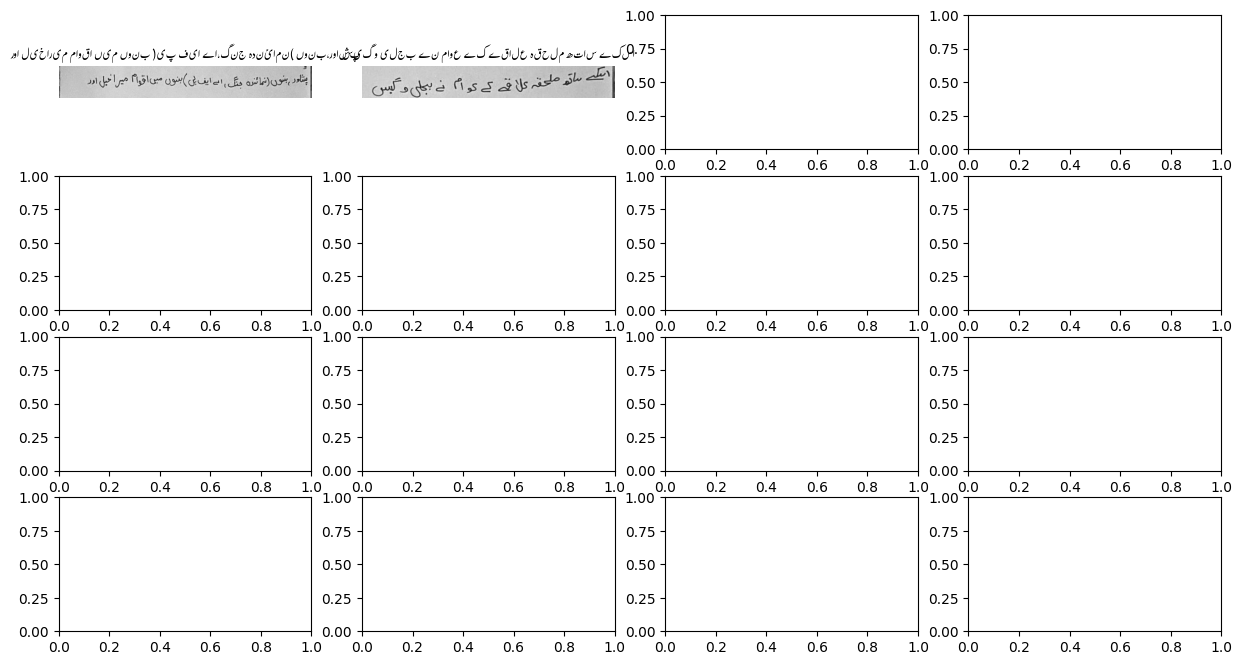

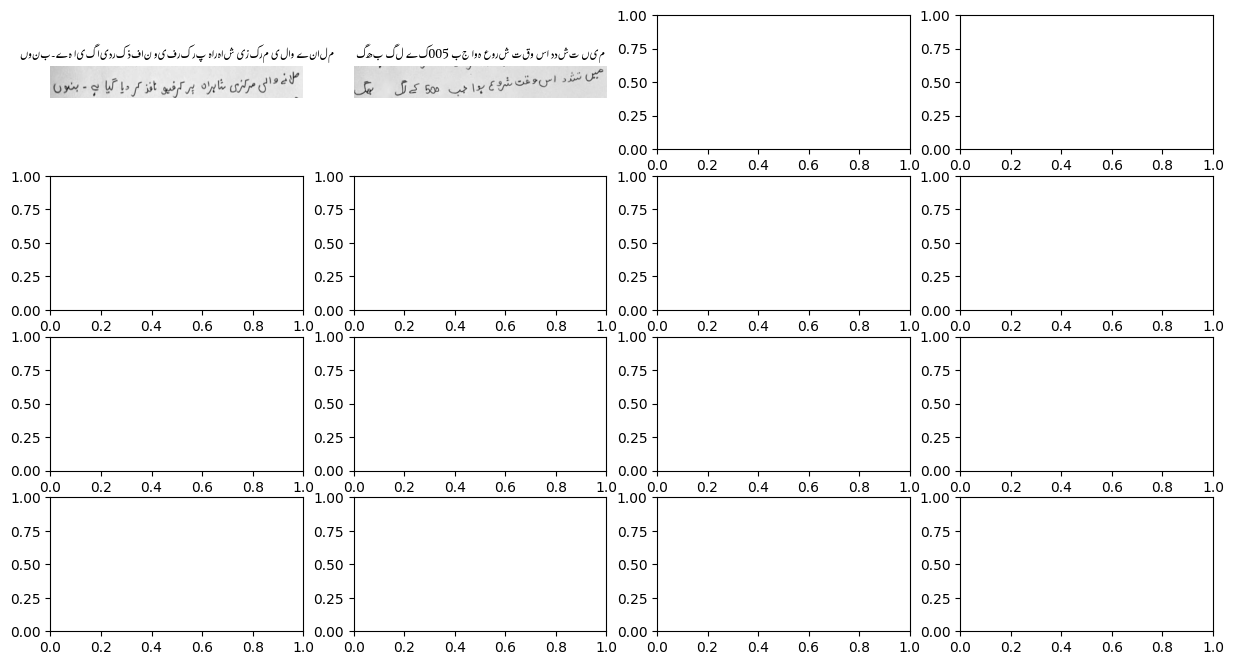

In [348]:
for data in train_ds.take(2):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(min(len(images),5)): # EDITTED HERE : changed from 16 to this
        img = images[i]
        # print("Original image shape:", img.shape)
        # img = tf.image.flip_left_right(img)

        # ADDING A SEGMENT HERE
        # START
        # Show the image directly
        # plt.imshow((tf.squeeze(img, axis=0)).numpy())  # Convert tensor to numpy array for display
        # plt.title("Original Image")
        # plt.axis("off")
        # plt.show()  # Display the image immediately
        img_shape = img.shape
        # print("Image shape before transpose:", img_shape)

        if len(img_shape) == 3:  # If it's a single image
            img = tf.transpose(img, perm=[1, 0, 2])  # Transpose only if it's 3D
        else:
            # If it's 4D, you might want to transpose specific dimensions.
            # print("Unexpected image shape, expected 3 dimensions but got:", img_shape)
            # squeeze the image
            img = tf.squeeze(img, axis=0)
            img = tf.transpose(img, perm=[1, 0, 2])  # Transpose only if it's 3D

        # END

        # print("Image after transpose:", img_shape)

        img = tf.transpose(img, perm=[1, 0, 2])

        print("Image after transpose:", img.shape)

        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        # START
        # Print the label to see what it writes
        print(f"Label for image {i}: {label}")
        # END

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label[::-1], fontproperties=font_prop)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [43]:
# # EDITTED VERSION

# for data in train_ds.take(2):
#     images, labels = data["image"], data["label"]

#     _, ax = plt.subplots(4, 4, figsize=(15, 8))

#     for i in range(len(images)):
#         img = images[i]

#         # Flip image horizontally if needed
#         img = tf.image.flip_left_right(img)

#         # Check if scaling is necessary based on the max value
#         img = (img * 255.0).numpy().astype(np.uint8) if tf.reduce_max(img) <= 1 else img.numpy().astype(np.uint8)

#         # Convert to grayscale if it's not already
#         if img.shape[-1] > 1:
#             img = img[:, :, 0]

#         # Gather indices where label != padding_token.
#         label = labels[i]
#         indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
#         # Convert to string.
#         label = tf.strings.reduce_join(num_to_char(indices))
#         label = label.numpy().decode("utf-8")

#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(label[::-1])
#         ax[i // 4, i % 4].axis("off")

# plt.show()


In [349]:
# START
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred
# END



# class CTCLayer(keras.layers.Layer):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = keras.backend.ctc_batch_cost

#     def call(self, y_true, y_pred):
#         batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#         input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#         label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#         input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         loss = self.loss_fn(y_true, y_pred, input_length, label_length)
#         self.add_loss(loss)

#         # At test time, just return the computed predictions.
#         return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x= keras.layers.BatchNormalization()(x)

    # After pooling, the output shape will be (None, 32, 256, 32)
    new_shape = (32, 256 * 32)
    # new_shape = ((image_width // 2), (image_height // 2) * 32)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # EDIT: # UpSampling layer to increase sequence length for CTC compatibility
    x = keras.layers.UpSampling1D(size=2, name="upsample")(x)

    x = keras.layers.Dense(16, activation="relu", name="dense2")(x)
    x= keras.layers.BatchNormalization()(x)

    # Add LSTM layer
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.35))(x)

    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense3"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.0001,
      decay_steps=10000,
      decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 512, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 512, 64, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 256, 32, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 256, 32, 32)    │            128 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 8192)       │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample (UpSampling1D)   │ (None, 64, 8192)       │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 64, 16)         │        131,088 │ upsample[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 64, 16)         │             64 │ dense2[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_41          │ (None, 64, 256)        │        148,480 │ batch_normalization_8… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense3 (Dense)            │ (None, 64, 62)         │         15,934 │ bidirectional_41[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 64, 62)         │              0 │ label[0][0],           │
│                           │                        │                │ dense3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 296,014 (1.13 MB)

 Trainable params: 295,918 (1.13 MB)

 Non-trainable params: 96 (384.00 B)

In [306]:
# validation_images = []
# validation_labels = []

# fixing dimensions
# for data in validation_ds:
#     images, labels = data["image"], data["label"]
#     # images = tf.squeeze(images, axis=1)
#     print(f"Image shape before transpose: {images.shape}")
#     # images = tf.transpose(images, perm=[0, 2, 1, 3])  # Reshape to (batch_size, 512, 64, 1)
#     validation_images.append(images)
#     validation_labels.append(labels)


In [353]:
# RUN ONLY ONCE!!

# Define a function to adjust the dimensions
def adjust_image_shape(data):
    images, labels = data["image"], data["label"]
    # Remove the unwanted dimension and transpose to match model's expected shape
    images = tf.squeeze(images, axis=1)
    images = tf.transpose(images, perm=[0, 2, 1, 3])  # Adjust to (batch_size, 512, 64, 1)
    return {"image": images, "label": labels}

# Apply the transformation to each dataset
train_ds = train_ds.map(adjust_image_shape)
validation_ds = validation_ds.map(adjust_image_shape)
test_ds = test_ds.map(adjust_image_shape)

In [358]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

print(validation_images[0].shape)
print(validation_labels[0].shape)

(2, 512, 64, 1)
(2, 61)


In [243]:
# def calculate_edit_distance(labels, predictions):
#     # Get a single batch and convert its labels to sparse tensors.
#     saprse_labels = tf.sparse.from_dense(labels)

#     # Make predictions and convert them to sparse tensors.
#     input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

#     predictions_decoded = keras.backend.ctc_decode(

#         predictions, input_length=input_len, greedy=False, beam_width=100,
#     )[0][0][:, :max_len]
#     sparse_predictions =tf.sparse.from_dense(predictions_decoded)

#     # Compute individual edit distances and average them out.
#     edit_distances = tf.edit_distance(
#         sparse_predictions, saprse_labels, normalize=False
#     )
#     return tf.reduce_mean(edit_distances)


# class EditDistanceCallback(keras.callbacks.Callback):
#     def __init__(self, pred_model):
#         super().__init__()
#         self.prediction_model = pred_model

#     def on_epoch_end(self, epoch, logs=None):
#         edit_distances = []

#         for i in range(len(validation_images)):
#             labels = validation_labels[i]
#             predictions = self.prediction_model.predict(validation_images[i])
#             edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

#         print(
#             f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
#         )

In [361]:
# START
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    sparse_labels = tf.sparse.from_dense(labels)

    # Set input lengths for CTC decoding.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    # Make predictions and convert them to sparse tensors.
    max_len = predictions.shape[1]  # Ensure max_len is defined properly.
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=False, beam_width=100
    )[0][0][:, :max_len]
    sparse_predictions = tf.sparse.from_dense(predictions_decoded)

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, sparse_labels, normalize=True
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            # Expand dims if needed to match batch size expectations
            # image = np.expand_dims(self.validation_images[i], axis=0)
            image = self.validation_images[i]
            # predictions = self.prediction_model.predict(image)
            predictions = self.prediction_model.predict([image, labels])
            # predictions = model.predict(validation_images, validation_labels)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")


# END

In [352]:
for layer in model.layers:
    print(layer.name)

image
Conv1
pool1
batch_normalization_82
reshape
upsample
dense2
batch_normalization_83
bidirectional_41
label
dense3
ctc_loss


In [362]:


epochs = 20  # To get good results this should be at least 50.

model = build_model()
# prediction_model = keras.models.Model(
#     model.get_layer(name="image").input,
#     model.get_layer(name="dense3").output
# )


prediction_model = keras.models.Model(
    model.input,
    model.get_layer(name="dense3").output
)
edit_distance_callback = EditDistanceCallback(prediction_model, validation_images, validation_labels)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    shuffle=True
)

#add early stopping mechanism

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Mean edit distance for epoch 1: 1.0471
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 446.2916 - val_loss: 484.2775
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Mean edit distance for epoch 2: 1.0492
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 436.6087 - val_loss: 432.3954
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mean edit distance for epoch 3: 1.0492
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 425.5169 - val_loss: 367.9197
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38

In [363]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    print(output_text)
    return output_text

In [367]:
# #  Let's check results on some test samples.
# for batch in test_ds.take(1):
#     batch_images = batch["image"]
#     batch_labels = batch["label"]
#     _, ax = plt.subplots(4, 4, figsize=(20, 8))

#     preds = prediction_model.predict([batch_images, batch_labels])
#     pred_texts = decode_batch_predictions(preds)

#     for i in range(min(len(test_ds), 5)):
#         img = batch_images[i]
#         img = tf.image.flip_left_right(img)
#         img = tf.transpose(img, perm=[1, 0, 2])
#         img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
#         img = img[:, :, 0]

#         title = f"Prediction: {pred_texts[i]}"
#         print(pred_texts[i]=='')
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")

# plt.show()


Original image shape 0: (512, 64, 1)
Transformed image shape 0: (64, 512, 1)
Original image shape 1: (512, 64, 1)
Transformed image shape 1: (64, 512, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
['    ی', 'ا    ی']
Label for image 0: 
False
Label for image 1: 
False


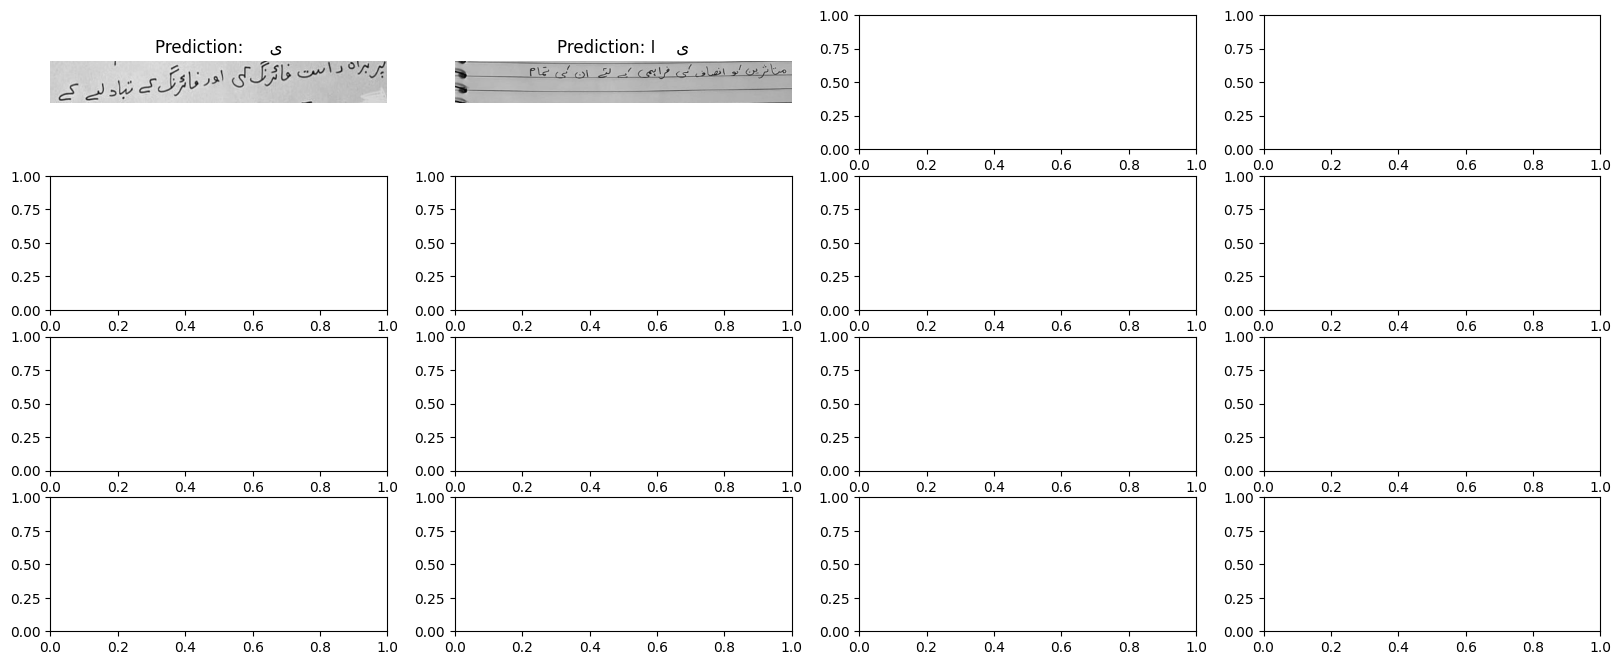

In [368]:
# START
# Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    _, ax = plt.subplots(4, 4, figsize=(20, 8))

    # Get predictions from the model
    preds = prediction_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)

    for i in range(min(len(batch_images), 16)):  # Ensure the range doesn't exceed the batch size
        img = batch_images[i]

        # Check if the image is 3D or 4D and apply transformations accordingly
        if img.ndim == 3:  # If it's a single image (height, width, channels)
            img = tf.transpose(img, perm=[1, 0, 2])  # Transpose if it's 3D
        else:  # If it's a batch (batch_size, height, width, channels)
            img = tf.squeeze(img, axis=0)  # Remove batch dimension
            img = tf.transpose(img, perm=[1, 0, 2])  # Then transpose

        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]  # Assuming the image has a single channel

        # Gather indices where label != padding_token for decoding the label
        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        # Print the label to see what it writes
        print(f"Label for image {i}: {label}")

        title = f"Prediction: {pred_texts[i]}"
        print(pred_texts[i] == '')
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

# END

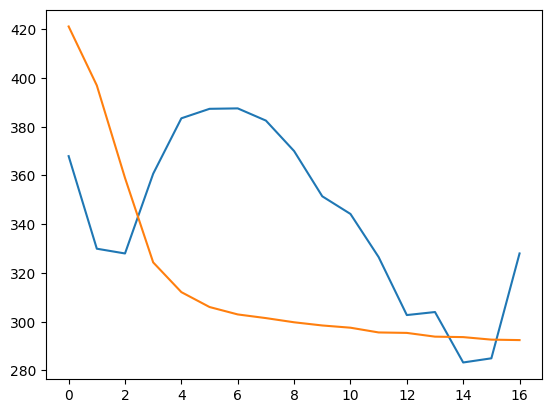

In [369]:
plt.plot(history.history['val_loss'][2:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][2:len(history.history['loss'])-1])

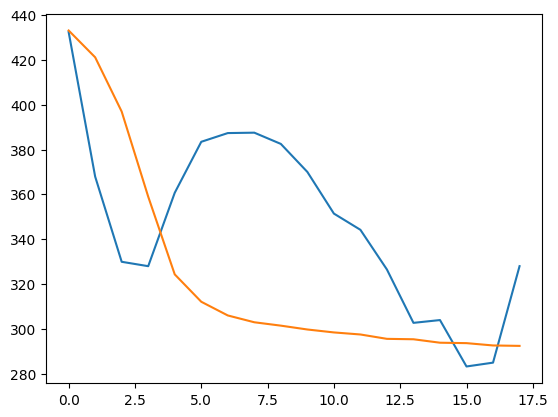

In [370]:
plt.plot(history.history['val_loss'][1:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][1:len(history.history['loss'])-1])

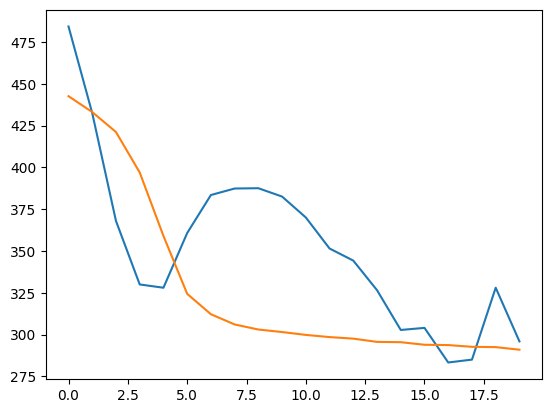

In [371]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])